# PredictAPrice

## As a property seller in Manhattan, what are factors that affect what you should price at?

### Datasets

We used NYC.gov's Rolling Sales data from the last 12 months, and 2 Zillow datasets: one showing all median prices and one of all square footage of properties sold. Both are in the year 2018. We merged all datasets together into a main dataframe.

### Data Cleaning

We filtered out all 0 value rows and extreme outliers.

### Transforming Data

When we plotted out our graphs, the normal distribution was postively skewed. We log transformed the data and the graph read much better.


### Checking Features for Usability

![Image of Yaktocat](https://octodex.github.com/images/yaktocat.png)

## Import all libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr


from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns


import matplotlib


# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics

## Access and Filter necessary info from 3 Real Estate datasets

In [26]:
#combined Rolling Sales Manhattan excel sheets for years 2016-2018
data=pd.read_excel("rollingsales_manhattan.xls", skiprows=1) 

##Filter 0 values and very extreme outliers 
data = data[data['SALE_PRICE'] > 100] 
data = data[data['SALE_PRICE'] < 250000000]  
data=data[data['GROSS SQUARE FEET'] > 100] 

#List of Columns pre-filtering
data.columns=['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE']

#Pull Sq ft data from Zillow Median Square Footage Excel File 
zillow_squarefootage=pd.read_excel("Zip_MedianListingPricePerSqft_AllHomes.xls")
zillow_squarefootage=zillow_squarefootage.loc[:,["RegionName","2018-10"]] 
zillow_squarefootage['ZIP_CODE']=zillow_squarefootage['RegionName']
zillow_squarefootage['ZillowSquareFootage']=zillow_squarefootage['2018-10']

#Pull Median Price data from Zillow Median Price Excel File
zillow_median_listing=pd.read_excel("Zip_MedianListingPrice_AllHomes.xls")
zillow_median_listing=zillow_median_listing.loc[:,["RegionName","2018-10"]] 
zillow_median_listing['ZIP_CODE']=zillow_median_listing['RegionName']
zillow_median_listing['ZillowMedianPrice']=zillow_median_listing['2018-10']

#Merge Zillow data together
new_df2= zillow_squarefootage.merge(zillow_median_listing, how = 'inner', on = ['ZIP_CODE'])
# new_df3=new_df2.merge(average_by_zip_2018, how = 'inner', on = ['ZIP_CODE'])

#Merge merged Zillow data with main excel Rolling Sales Data
new_df3= data.merge(new_df2, how = 'inner', on = ['ZIP_CODE'])
new_df=new_df3.copy()
new_df=new_df.drop(columns=['RegionName_y', 'RegionName_x',"2018-10_x","2018-10_y"])
new_df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE', 'ZillowSquareFootage', 'ZillowMedianPrice'],
      dtype='object')

In [27]:
new_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,ZillowSquareFootage,ZillowMedianPrice
0,1,CLINTON,08 RENTALS - ELEVATOR APARTMENTS,2,1071,42,,D6,520 WEST 43RD STREET,,...,380,24100,319967,1996,2,D6,193000000,2018-08-01,1659.125189,1310000.0
1,1,CLINTON,29 COMMERCIAL GARAGES,4,1076,1,,G8,646 11TH AVENUE,,...,2,30125,50207,1946,4,G8,93125000,2018-06-08,1659.125189,1310000.0
2,1,MIDTOWN WEST,21 OFFICE BUILDINGS,4,1263,56,,O5,32 WEST 48TH STREET,,...,61,8234,33837,1924,4,O5,40000000,2018-10-26,1659.125189,1310000.0
3,1,CLINTON,26 OTHER HOTELS,4,1076,57,,H3,548 WEST 48TH STREET,,...,1,5021,28540,2010,4,H3,29168078,2017-12-27,1659.125189,1310000.0
4,1,CLINTON,07 RENTALS - WALKUP APARTMENTS,2,1055,55,,C4,444 WEST 46TH STREET,,...,20,2510,9810,1901,2,C4,2643864,2018-09-21,1659.125189,1310000.0


## Data Cleaning and Deciding what features to use

In [28]:
#Change the datatype of Zillow Median Price and Square Footage from Float to Integer
new_df['ZillowMedianPrice'] = new_df['ZillowMedianPrice'].astype(int)
new_df['ZillowSquareFootage'] = new_df['ZillowSquareFootage'].astype(int)

#Set target (Y value) = sales price / #Set features (X values) = all columns (will drop all unecessary)
target=new_df[["SALE_PRICE"]]
features= new_df 

#Drop unecessary features, maybe drop both Zillow data columns
features=features.drop(columns=["SALE_DATE",'BOROUGH',                     
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 
        'TOTAL_UNITS',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
      'SALE_PRICE','ZillowSquareFootage', 'ZillowMedianPrice',]) 

##Data Cleaning
#Strip duplicate BUILDING CLASS CATEGORY and NEIGHBORHOOD categories
features["BUILDING_CLASS_CATEGORY"]=features["BUILDING_CLASS_CATEGORY"].str.strip()
features["BUILDING_CLASS_CATEGORY"]=features["BUILDING_CLASS_CATEGORY"].str.replace(' ', '')
features["NEIGHBORHOOD"]=features["NEIGHBORHOOD"].str.strip()
features["NEIGHBORHOOD"]=features["NEIGHBORHOOD"].str.replace(' ', '')

#Set Category Variables
cat_vars=features[['BUILDING_CLASS_CATEGORY',"NEIGHBORHOOD","ZIP_CODE"]]

In [29]:
features.head()

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT
0,CLINTON,08RENTALS-ELEVATORAPARTMENTS,10036,375,5,24100,319967,1996
1,CLINTON,29COMMERCIALGARAGES,10036,0,2,30125,50207,1946
2,MIDTOWNWEST,21OFFICEBUILDINGS,10036,0,61,8234,33837,1924
3,CLINTON,26OTHERHOTELS,10036,0,1,5021,28540,2010
4,CLINTON,07RENTALS-WALKUPAPARTMENTS,10036,20,0,2510,9810,1901


## Change Category Variables to Dummy Variables

In [31]:
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(features[var], prefix=var)#,drop_first=True)
    data1=features.join(cat_list)
    features=data1
data_vars=features.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
features=features[to_keep]


## Graph out Sale Price Distribution

/Users/chrischung/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


skewness: 4.750264
kurtosis: 26.823504


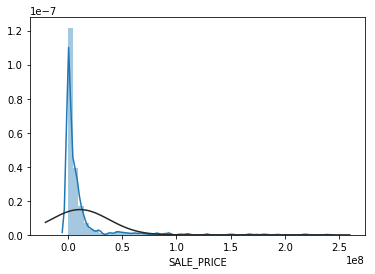

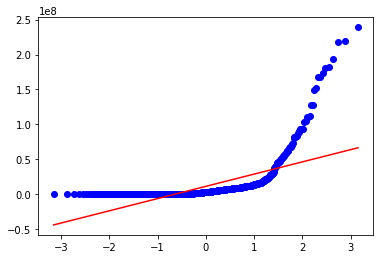

In [32]:
new_df["SALE_PRICE"].describe()
sns.distplot(new_df.SALE_PRICE,fit=norm);
plt.ylabel =('Frequency')
plt.title = ('SalePrice Distribution');
#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(new_df["SALE_PRICE"]);
#QQ plot
fig = plt.figure()
res = stats.probplot(new_df["SALE_PRICE"], plot=plt)
# plt.show()
print("skewness: %f" % new_df["SALE_PRICE"].skew())
print("kurtosis: %f" % new_df["SALE_PRICE"].kurt())

## Transform Data

/Users/chrischung/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


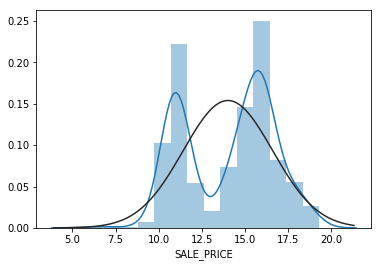

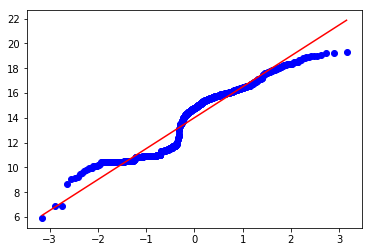

In [33]:
#notes
#Plotted the distribution of the SALE_PRICE and normal probability graph which is used to identify substantive departures from normality. This includes identifying outliers, skewness and kurtosis. Used the QQ-plot
#log transform the target 
new_df["SALE_PRICE"] = np.log1p(new_df["SALE_PRICE"])

#Kernel Density plot
sns.distplot(new_df.SALE_PRICE,fit=norm);
plt.ylabel=('Frequency')
plt.title=('SalePrice distribution');
#Get the fitted parameters used by the function
(mu,sigma)= norm.fit(new_df["SALE_PRICE"]);
#QQ plot
fig =plt.figure()
res =stats. probplot(new_df["SALE_PRICE"], plot=plt)
plt.show()


# # Step 1: Checking for Linearity  using Scatterplots

/Users/chrischung/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


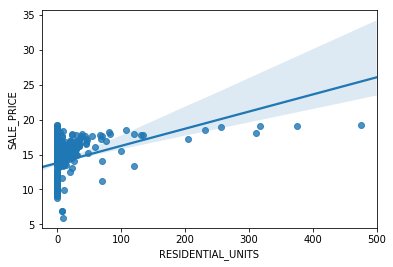

In [34]:

sns.regplot(y=new_df.SALE_PRICE, x=new_df['RESIDENTIAL_UNITS'], data=new_df, fit_reg = True)


/Users/chrischung/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


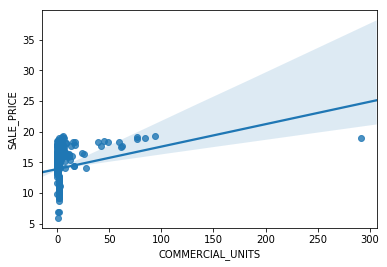

In [35]:
sns.regplot(y=new_df.SALE_PRICE, x=new_df['COMMERCIAL_UNITS'], data=new_df, fit_reg = True)



/Users/chrischung/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


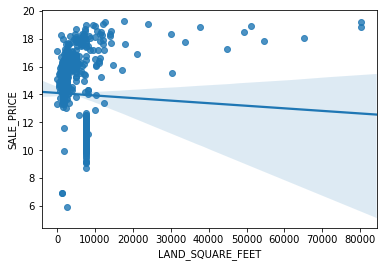

In [36]:
sns.regplot(y=new_df.SALE_PRICE, x=new_df['LAND_SQUARE_FEET'], data=new_df, fit_reg = True)

/Users/chrischung/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


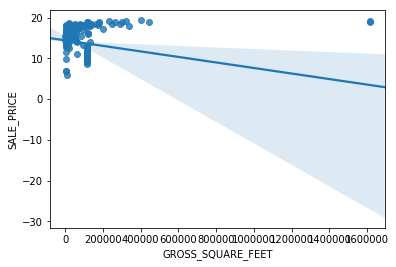

In [37]:
sns.regplot(y=new_df.SALE_PRICE, x=new_df['GROSS_SQUARE_FEET'], data=new_df, fit_reg = True)


# Graph showing the distribution of prices by neighborhoood

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 <a list of 45 Text xticklabel objects>)

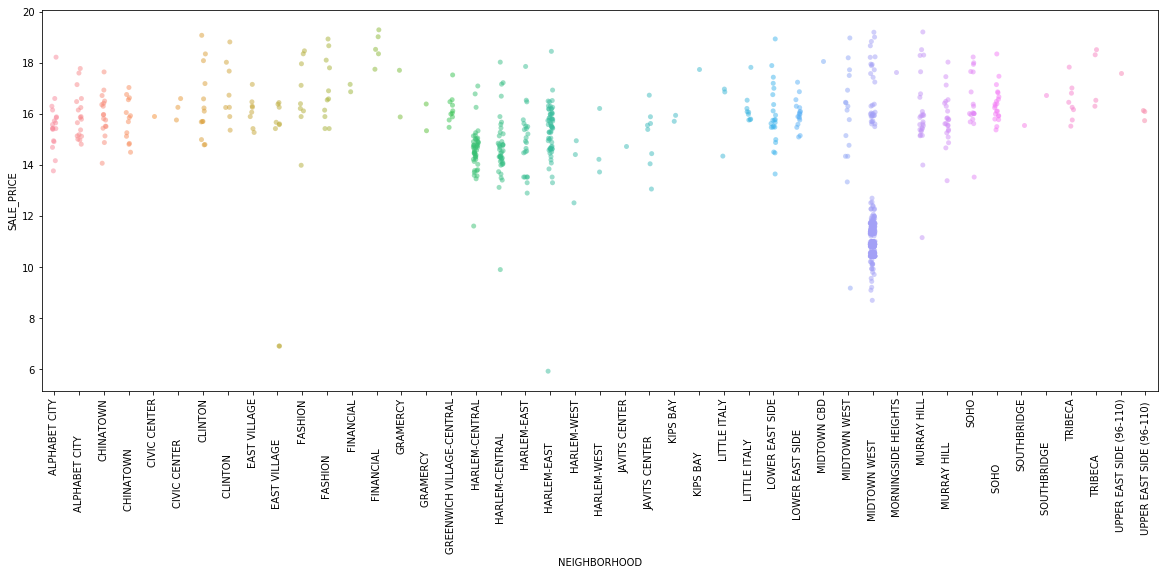

In [38]:

plt.figure(figsize=(20,7))
sns.stripplot(x = new_df.NEIGHBORHOOD, y = new_df.SALE_PRICE,
              order = np.sort(new_df.NEIGHBORHOOD.unique()),
              jitter=0.1, alpha=0.5)
plt.xticks(rotation=90)




# Distribution of square footage and sale price

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

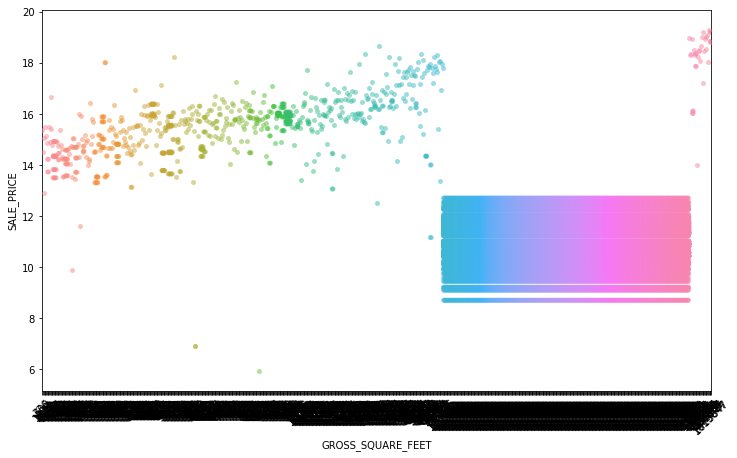

In [39]:

plt.figure(figsize=(12,7))
sns.stripplot(x = new_df.GROSS_SQUARE_FEET, y = new_df.SALE_PRICE,
              order = np.sort(new_df.GROSS_SQUARE_FEET),
              jitter=0.1, alpha=0.5)
plt.xticks(rotation=45)

# Distribution of homes built by year 

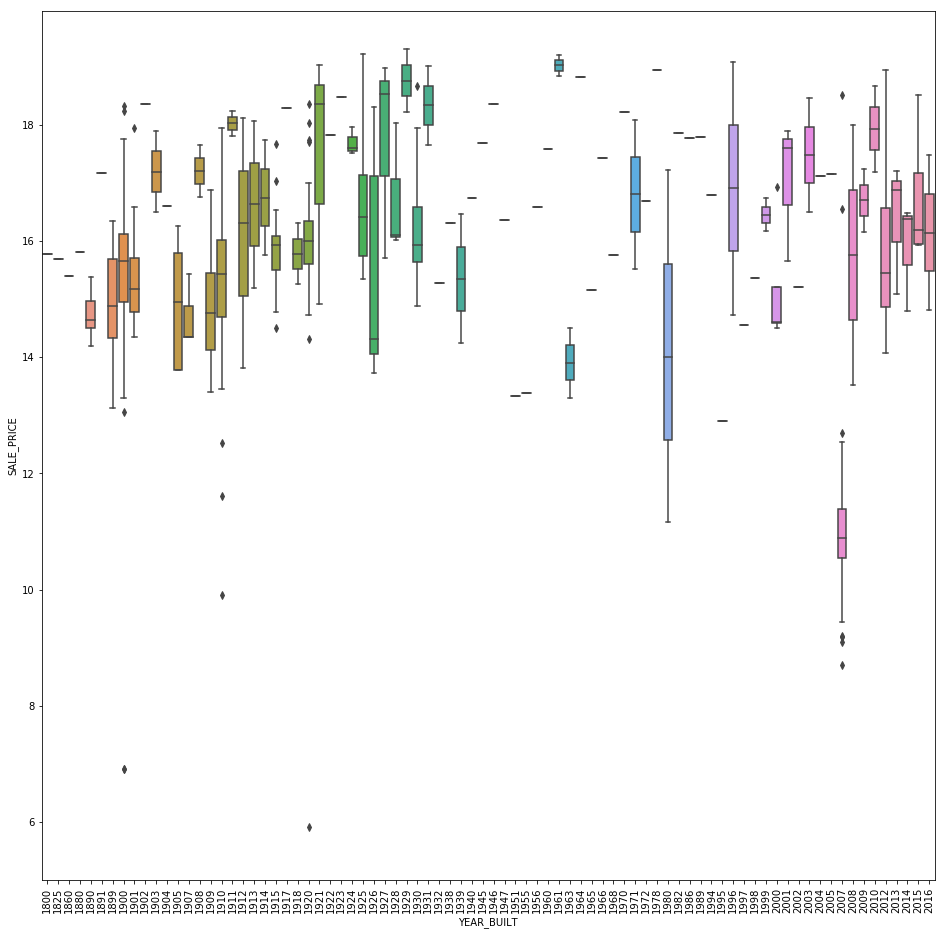

In [40]:
var  = 'YEAR_BUILT'
data= pd.concat([new_df['SALE_PRICE'], new_df[var]], axis =1)
f, ax = plt.subplots(figsize=(16, 16))
fig = sns.boxplot(x=var, y=new_df['SALE_PRICE'], data=data)
fig.axis(ymin=5)
plt.xticks(rotation=90);
plt.show();

## Correlation of Features

In [45]:
features.corr() >.75

,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT
ZIP_CODE,True,False,False,False,False,False
RESIDENTIAL_UNITS,False,True,False,False,False,False
COMMERCIAL_UNITS,False,False,True,False,False,False
LAND_SQUARE_FEET,False,False,False,True,True,False
GROSS_SQUARE_FEET,False,False,False,True,True,False
YEAR_BUILT,False,False,False,False,False,True


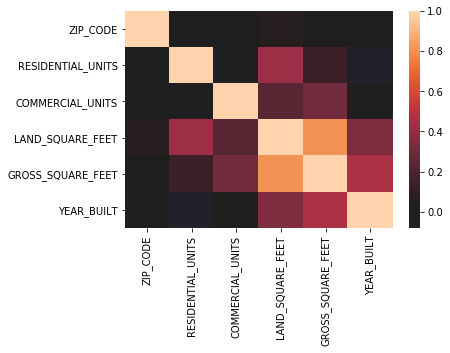

In [47]:
import seaborn as sns
sns.heatmap(features.corr(), center=0);

# Regression Info Below
# Features described first 

In [41]:

features.describe()

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,...,ZIP_CODE_10009,ZIP_CODE_10012,ZIP_CODE_10013,ZIP_CODE_10016,ZIP_CODE_10018,ZIP_CODE_10019,ZIP_CODE_10027,ZIP_CODE_10029,ZIP_CODE_10036,ZIP_CODE_10038
count,866.000000,866.000000,866.000000,8.660000e+02,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,...,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000
mean,9.247113,2.975751,5549.627021,5.932070e+04,1952.683603,0.032333,0.026559,0.021940,0.259815,0.049654,...,0.060046,0.028868,0.080831,0.066975,0.033487,0.420323,0.112009,0.100462,0.025404,0.004619
std,31.859502,12.372564,6301.376164,9.459625e+04,48.081714,0.176984,0.160883,0.146572,0.438787,0.217354,...,0.237710,0.167533,0.272734,0.250122,0.180009,0.493896,0.315560,0.300789,0.157440,0.067845
min,0.000000,0.000000,0.000000,3.360000e+02,1800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2124.250000,6.251500e+03,1910.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,4966.500000,2.035950e+04,1925.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,2.000000,7532.000000,1.128500e+05,2007.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,476.000000,292.000000,80333.000000,1.613847e+06,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Of the 5 original features used [RESIDENTIAL_UNITS, COMMERCIAL_UNITS, LAND_SQUARE_FEET, GROSS_SQUARE_FEET and YEAR_BUILT], only the LAND_SQUARE_FEET had a P value above 0.05. Its value was 0.219

# R^2 total using 4 features = 0.727 

In [42]:
# GROSS_SQUARE_FEET:0.645
# Residential Units: 0.071
# COMMERCIAL_UNITS :0.098
# LAND_SQUARE_FEET:0.534
# YEAR_BUILT:0.000
#ZillowSquareFootage:0.006... pvalue of 0.024
#ZillowMedianPrice0.012...pvalue of 0.001
#ALL WITH ZILLOW: 0.729

m7 = ols('SALE_PRICE ~RESIDENTIAL_UNITS+COMMERCIAL_UNITS+GROSS_SQUARE_FEET+YEAR_BUILT',new_df).fit()
print(m7.summary())
m1 = ols('SALE_PRICE ~GROSS_SQUARE_FEET',new_df).fit()
print(m1.summary())
# m2 = ols('SALE_PRICE ~RESIDENTIAL_UNITS ',new_df).fit()
# print(m2.summary())
# m3 = ols('SALE_PRICE ~COMMERCIAL_UNITS ',new_df).fit()
# print(m3.summary())
# m4 = ols('SALE_PRICE ~LAND_SQUARE_FEET ',new_df).fit()
# print(m4.summary())
m5 = ols('SALE_PRICE ~GROSS_SQUARE_FEET ',new_df).fit()
print(m1.summary())
# m6 = ols('SALE_PRICE ~YEAR_BUILT ',new_df).fit()
# print(m6.summary())


#####regression for zillow items below 
# m8 = ols('SALE_PRICE ~ZillowSquareFootage ',new_df).fit()
# print(m8.summary())
# m9 = ols('SALE_PRICE ~ZillowMedianPrice ',new_df).fit()
# print(m9.summary())
# m10 = ols('SALE_PRICE ~RESIDENTIAL_UNITS+ZillowSquareFootage+ZillowMedianPrice+COMMERCIAL_UNITS+LAND_SQUARE_FEET+GROSS_SQUARE_FEET+YEAR_BUILT ',new_df).fit()
# print(m10.summary())

1- (RSS/TSS)

                            OLS Regression Results                            
Dep. Variable:             SALE_PRICE   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     326.2
Date:                Fri, 07 Dec 2018   Prob (F-statistic):          8.86e-171
Time:                        13:33:48   Log-Likelihood:                -1653.8
No. Observations:                 866   AIC:                             3318.
Df Residuals:                     861   BIC:                             3341.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            84.9087      2.60

In [43]:
reg = LinearRegression()

In [22]:
new_df

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,ZillowSquareFootage,ZillowMedianPrice
0,1,CLINTON,08 RENTALS - ELEVATOR APARTMENTS,2,1071,42,,D6,520 WEST 43RD STREET,,...,380,24100,319967,1996,2,D6,19.078201,2018-08-01,1659,1310000
1,1,CLINTON,29 COMMERCIAL GARAGES,4,1076,1,,G8,646 11TH AVENUE,,...,2,30125,50207,1946,4,G8,18.349453,2018-06-08,1659,1310000
2,1,MIDTOWN WEST,21 OFFICE BUILDINGS,4,1263,56,,O5,32 WEST 48TH STREET,,...,61,8234,33837,1924,4,O5,17.504390,2018-10-26,1659,1310000
3,1,CLINTON,26 OTHER HOTELS,4,1076,57,,H3,548 WEST 48TH STREET,,...,1,5021,28540,2010,4,H3,17.188585,2017-12-27,1659,1310000
4,1,CLINTON,07 RENTALS - WALKUP APARTMENTS,2,1055,55,,C4,444 WEST 46TH STREET,,...,20,2510,9810,1901,2,C4,14.787752,2018-09-21,1659,1310000
5,1,MIDTOWN WEST,22 STORE BUILDINGS,4,1034,31,,K4,687 8 AVENUE,,...,5,2017,7760,1920,4,K4,16.436549,2018-05-16,1659,1310000
6,1,CLINTON,07 RENTALS - WALKUP APARTMENTS,2,1053,6,,C4,459 WEST 43RD STREET,,...,13,2510,6640,1910,2,C4,16.231424,2018-01-24,1659,1310000
7,1,CLINTON,07 RENTALS - WALKUP APARTMENTS,2A,1058,113,,C3,435 WEST 48TH STREET,,...,4,2510,6560,1910,2,C3,15.706361,2018-07-30,1659,1310000
8,1,MIDTOWN WEST,22 STORE BUILDINGS,4,1263,55,,K9,30 WEST 48TH STREET,,...,5,2070,6350,1920,4,K9,16.146975,2018-10-26,1659,1310000
9,1,MIDTOWN WEST,22 STORE BUILDINGS,4,1263,21,,K2,25 WEST 47TH STREET,,...,26,2397,5643,1938,4,K2,16.299348,2018-10-26,1659,1310000


In [44]:
train1= features # can change to scaled_features or features to test regresion model with or without categorical values 
labels=target


In [45]:
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.20,random_state =30)

In [83]:
lm = LinearRegression()
lm.fit(x_train,y_train)

# evaluation using r-square

lm.score(x_train,y_train)
# x_test

0.7317281102976905

### We create a scatterplot between the predicted prices, (where m is the fitted model) and the original prices. 

# A perfect model would get us a scatterplot where all the data lies on the 45 degree line. 

# Data  shows we are more accurate when we hit prices around 160 million

In [52]:
import matplotlib.pyplot as plt

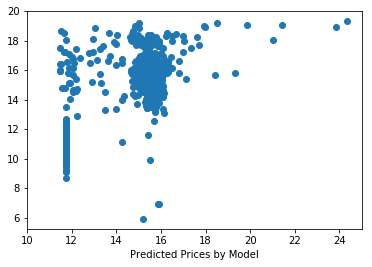

In [63]:
predicted_prices = m7.fittedvalues

plt.scatter(predicted_prices, new_df.SALE_PRICE)
plt.xlabel("Predicted Prices by Model")
plt.ylabel='Original Prices'
plt.title='Predictions vs. Original Prices'
plt.xlim((10,25))
plt.show()



Text(0.5,0,'Fitted Values')

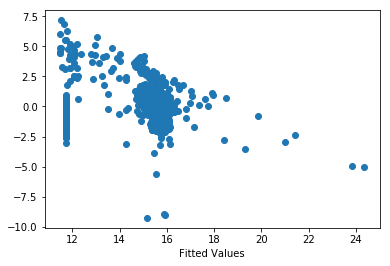

In [57]:
x = m7.fittedvalues
y = m7.resid
plt.scatter(x, y)

plt.xlabel("Fitted Values")
# plt.ylabel("Residual")
# plt.title("Fitted Values vs. Residuals")

## the model is predicting heteroskedastically, 
because we are overpredicting the price when the actual price is low and underpredicting when it is high

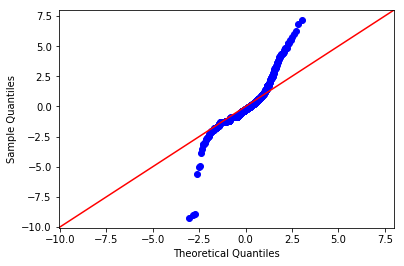

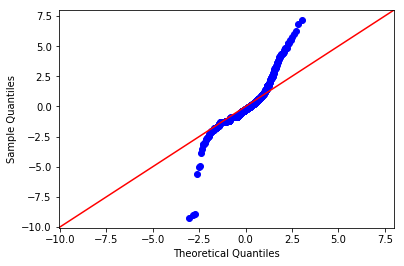

In [64]:
sm.qqplot(m7.resid,line='45')

In [82]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))/np.std(y_train)

SALE_PRICE    0.502126
dtype: float64

In [67]:
reg.fit(x_train,y_train)
reg.score(x_test,y_test) 
#highest score with all variables (2110) is .79

0.7250078942974605

In [69]:
y_pred = lm.predict(x_test) #from seans ridge nad lasso slides 

print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


MSE: 184264415698494.62
RMSE: 13574402.959191047


## Overall Metrics

* Root Mean Square Error : 13574402.959191047

In [28]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test, y_pred)
# sklearn.metrics.median_absolute_error(y_true, y_pred)[source]

1585151.4366711155

## Next Steps

* Regularization (with Lasso and Ridge)
* Determine why our predictions are heteroskedastic.

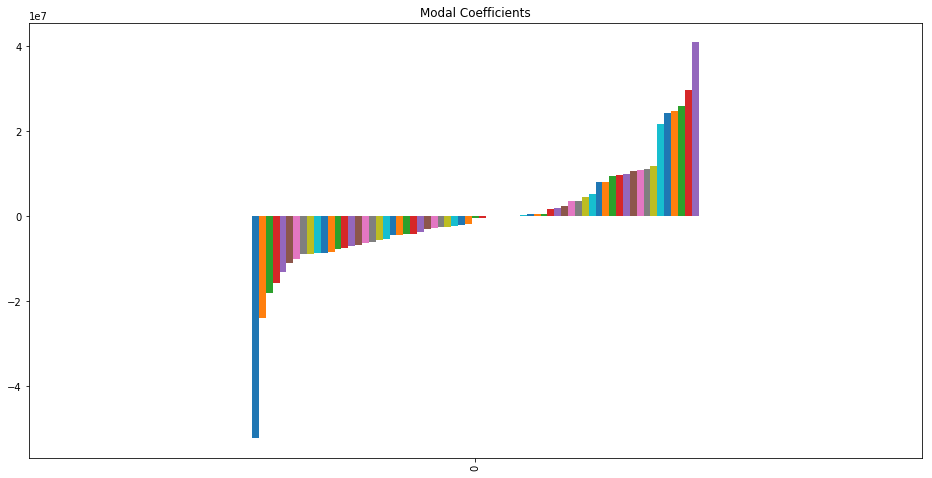

In [29]:
coef = pd.DataFrame(data=lm.coef_, columns=x_train.columns ) #takes co-effficent and pairs up with columns, and looks at 

model_coef = coef.T.sort_values(by=0).T

model_coef.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [30]:
y_test.std()

SALE_PRICE    2.596045e+07
dtype: float64

MSE: 247987123402372.03
RMSE: 15747606.91033314
SALE_PRICE    0.6066
dtype: float64


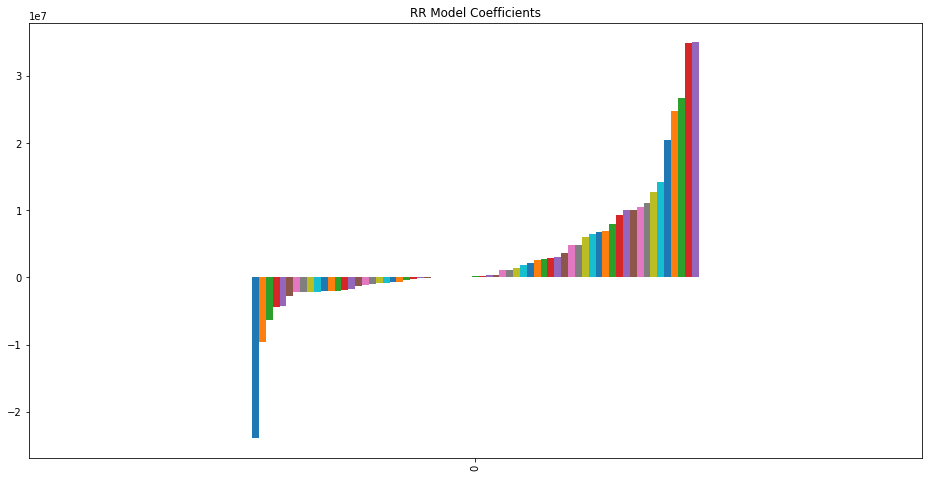

In [31]:
X_train=x_train #***
X_test=x_test
ridgeReg = Ridge(alpha=.50, normalize=True)

ridgeReg.fit(X_train,y_train)

y_pred = ridgeReg.predict(X_test)

#calculating mse

print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/ y_test.std())
coef = pd.DataFrame(data=ridgeReg.coef_, columns=X_train.columns )

model_coef = coef.T.sort_values(by=0).T

model_coef.plot(kind='bar', title='RR Model Coefficients', legend=False, figsize=(16,8))

MSE: 218642713567700.6
RMSE: 14786572.069540005
SALE_PRICE    0.569581
dtype: float64


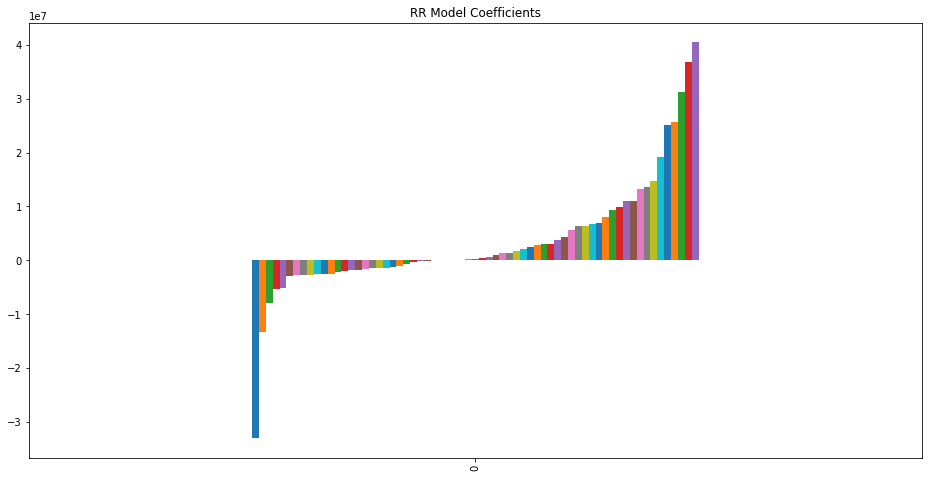

In [32]:
#Identifing Outliers
X_train=x_train #***
X_test=x_test
ridgeReg = Ridge(alpha=.20, normalize=True)

ridgeReg.fit(X_train,y_train)

y_pred = ridgeReg.predict(X_test)

#calculating mse

print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/ y_test.std())
coef = pd.DataFrame(data=ridgeReg.coef_, columns=X_train.columns )

model_coef = coef.T.sort_values(by=0).T

model_coef.plot(kind='bar', title='RR Model Coefficients', legend=False, figsize=(16,8))

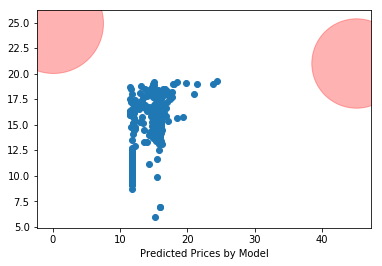

In [33]:
plt.scatter(-0, 25, s=10000, alpha=0.3, c = 'r' )
plt.scatter(45, 21, s=8000, alpha=0.3, c = 'r' )


predicted_prices = m7.fittedvalues

plt.xlabel("Predicted Prices by Model")
# plt.ylabel()
# plt.title("Predictions vs. Original Prices")
plt.scatter(predicted_prices, new_df.SALE_PRICE)


/Users/chrischung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


MSE: 184445775930621.6
RMSE: 13581081.544951476
SALE_PRICE    0.523145
dtype: float64


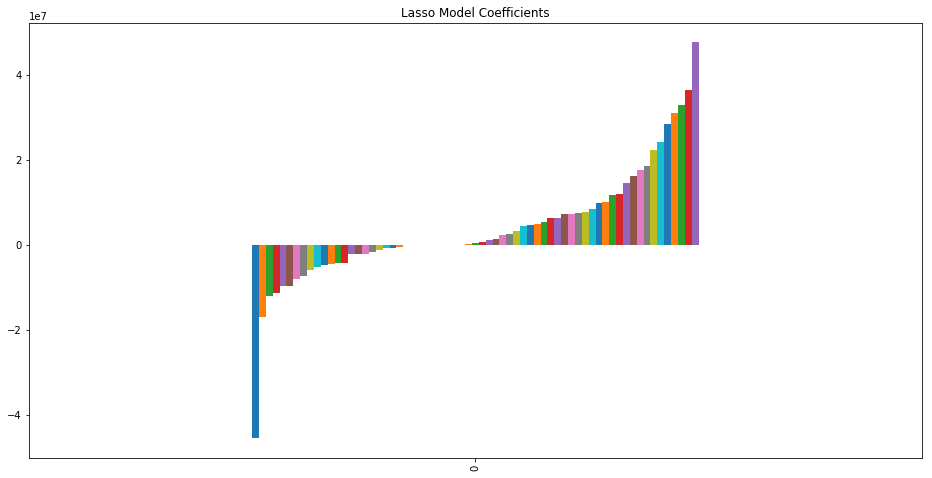

In [34]:
#***Lasso regression not only helps in reducing over-fitting but it can help us in feature selection.
from sklearn.linear_model import Lasso


lassoReg = Lasso(alpha=50, normalize=True)

lassoReg.fit(X_train,y_train)

y_pred = lassoReg.predict(X_test)

#calculating mse

print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/ y_test.std())



coef = pd.DataFrame(data=lassoReg.coef_, index=X_train.columns )
model_coef = coef.sort_values(by=0).T

model_coef.plot(kind='bar', title='Lasso Model Coefficients', legend=False, figsize=(16,8))


In [35]:
from sklearn.feature_selection import RFE
rfe = RFE(lm, n_features_to_select=10)
rfe.fit(features_selected_train,y_train)

NameError: name 'features_selected_train' is not defined

In [ ]:

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.distplot(new_df.SALE_PRICE, bins = 25)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price in USD")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")


In [ ]:
# x_test

In [ ]:
from sklearn import preprocessing
from sklearn import pipeline

scaler = preprocessing.StandardScaler()
X_test=x_test#[['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'LAND_SQUARE_FEET','GROSS_SQUARE_FEET', 'YEAR_BUILT']]
X_test1=x_test#[['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'LAND_SQUARE_FEET','GROSS_SQUARE_FEET', 'YEAR_BUILT',"BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS"]]
X_test1=x_test[['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'LAND_SQUARE_FEET','GROSS_SQUARE_FEET', 'YEAR_BUILT',"BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS"]]
X_train=x_train

In [ ]:
scaler.fit(features.iloc[:,:-1])


In [ ]:
len(X_test1.columns[:-1])
len(X_test1.iloc[:,:-1])
X_test1.columns.shape

In [ ]:
scaler.fit(X_train.iloc[:,:-1])
features_scaled_train = pd.DataFrame(scaler.transform(X_train.iloc[:,:-1]), columns=X_train.columns[:-1], index=X_train.index)

features_scaled_train.head()

In [ ]:
features_scaled_test = pd.DataFrame(scaler.transform(X_test.iloc[:,:-1]), columns=X_test.columns[:-1], index=X_test.index)

features_scaled_test.head()

In [ ]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_64_train = pd.DataFrame(poly.fit_transform(features_scaled_train), columns=poly.get_feature_names(features_scaled_train.columns))
features_64_train.head()


In [ ]:
pd.set_option('display.max_columns', 100)
features_64_train.head()
features_64_test = pd.DataFrame(poly.fit_transform(features_scaled_test), columns=poly.get_feature_names(features_scaled_test.columns))
features_64_test.head()

In [ ]:
***

In [ ]:
from sklearn.feature_selection import VarianceThreshold
thresholder = VarianceThreshold(threshold=.5)

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [ ]:
features_selected_train = variance_threshold_selector(features_64_train)
# features_selected_train = variance_threshold_selector(features_64_train)

In [ ]:
features_selected_train.head()

In [ ]:
import seaborn as sns

sns.set(style="white")


# Compute the correlation matrix
corr = features_selected_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Create correlation matrix
corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [ ]:
upper

In [ ]:
features_selected_train.drop(columns=to_drop, inplace=True)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

In [ ]:
def information_selector(X, y, scoring, k=5):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]
test = SelectKBest(score_func=mutual_info_regression, k=30)
fit = test.fit(features_selected_train, y_train)

In [ ]:
features_selected_train[features_selected_train.columns[fit.get_support(indices=True)]].head()

In [ ]:
features_selected_train = information_selector(features_selected_train, y_train, mutual_info_regression, k=30)

In [ ]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train, y_train)

In [ ]:
features_selected_test = features_64_test[features_selected_train.columns]
y_pred = lm.predict(features_selected_test)

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(lm, n_features_to_select=10)
rfe.fit(features_selected_train,y_train)

In [ ]:
def ranking(ranks, names, order=1):

    ranks = map(lambda x: (x,2), ranks)
    return list(sorted(zip(ranks, names),reverse=True))

In [ ]:
rankings = ranking(np.abs(lm.coef_), features_selected_train.columns)

In [ ]:
rankings[:15]

In [ ]:
[item[1] for item in rankings[0:15]]

In [ ]:
final_columns = [item[1] for item in rankings[0:15]]


In [ ]:
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train[final_columns], y_train)

In [ ]:
features_selected_test = features_64_test[final_columns]
y_pred = lm.predict(features_selected_test)

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
def 

In [ ]:
#look at each distribtions, graph them all 

In [ ]:
model.summary() #y variale is 799.36

In [ ]:
### Module 2 Projects

Projects are designed to review the material we covered in Module 2:

* cleaning data with numpy and pandas
* probability and combinatorics
* probability distributions
* hypothesis testing
* simple linear regression
* multiple linear regression
* cross validation and the bias/variance tradeoff

Ask a main question with which you can use a regression to answer. The other topics we learned in Module 2 can be used as further justification for your answers to subsequent questions.

Sample Questions:

* What best determines the final auction price of an item?
* What are the key factors in determining a country's happiness level?
* Is there a way we can predict the spread of a football game?


### Data
* You must have at least 4 different features in your models (independent variables) with at least one target (dependent variable).
* Your data must contain at least one categorical feature and at least one numerical feature
* **BONUS**: Challenge yourself to obtain a unique dataset (either from webscraping or querying APIs)

### The Deliverables

1. ** A well documented Jupyter Notebook** containing any code you've written for this project, comments explaining it, and graphical visualizations.

## Requirements

#### Organization/Code Cleanliness

* The notebook should be well organized, easy to follow,  and code should be commented where appropriate.  
    * Level Up: The notebook contains well-formatted, professional looking markdown cells explaining any substantial code. All functions have docstrings that act as professional-quality documentation
* The notebook is written for a technical audiences with a way to both understand your approach and reproduce your results. The target audience for this deliverable is other data scientists looking to validate your findings.

#### Visualizations & EDA (Exploratory Data Analysis)

* Your project contains at least 4 _meaningful_ data visualizations, with corresponding interpretations. All visualizations are well labeled with axes labels, a title, and a legend (when appropriate)  
* You pose at least 3 meaningful questions and answer them through EDA.  These questions should be well labeled and easy to identify inside the notebook.
    * **Level Up**: Each question is clearly answered with a visualization that makes the answer easy to understand.   
* Your notebook should contain 1 - 2 paragraphs briefly explaining your approach to this project.


#### Model Quality/Approach

* Your model should not include any predictors with p-values greater than .05 (unless you can justify)
* Your model should have cross-validation and account for the bias-variance tradeoff  
* Your notebook shows an iterative approach to modeling, and details the parameters and results of the model at each iteration.  
    * **Level Up**: Whenever necessary, you briefly explain the changes made from one iteration to the next, and why you made these choices.  
* You provide at least 1 paragraph explaining your final model.   